In [1]:
%matplotlib inline
##########################################
#00          I/O                         #
#   a- import libraries.                 #
#   b- associate database to 'engine'.   #
#   c- set global charting style.        #
##########################################

#a
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

#b
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#c
plt.style.use('fivethirtyeight')

In [2]:
#########################################
#00.1    Database Connections           #
#     a- reflect database and tables.   #
#     b- print list of tables.          #
#     c- associate tables.              #
#     d- create session link.           #
#########################################

#a
Base = automap_base()
Base.prepare(engine, reflect=True)

#b
print(Base.classes.keys())

#c
Measurement = Base.classes.measurement
Station = Base.classes.station

#d
session = Session(engine)

['measurement', 'station']


In [3]:
##############################################################################################################
#01        Table Extract                                                                                     #
#   -a sort to put most recent date on top.                                                                  #
#      take the first occurance of date [0] and remove from results list [0].                                #
#   -b split into year,month,day & convert to integers.                                                      #                  
#   -c call datetime to subtract one year(as 365 days)- this is done to show a known ability (for trilogy).  #
#     - as datetime has no 'year'value we can not be accurate without adding additional code for leap        #
#       year considerations. a simpler solution woulb be to subtract one from the year ourselves.            #
#   -d query Measurement table for past years' worth of precipitation data.                                  #
##############################################################################################################

#a
sorted = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
most_recent = sorted[0][0]

#b
year,month,day = most_recent.split('-')
year,month,day = int(year), int(month), int(day)

#c
last_year = dt.date(year,month,day)- dt.timedelta(days=365)

#d
past_year_rain = session.query(Measurement.date, Measurement.prcp).\
                 filter(Measurement.date >= last_year).\
                 filter(Measurement.prcp != "None").\
                 order_by(Measurement.date).all()

In [4]:
###################################################################
#02      Create DataFrame                                         #
#   a- create pd.df from query extract, set index to date.        #
#   b- group by date and get average rainfall between stations.   #
###################################################################

#a
rain_df = pd.DataFrame(past_year_rain).set_index("date")
rain_df.sort_values("date",inplace=True)

#b
rain_grouped = round(rain_df.groupby("date").mean(), 2)

<Figure size 432x288 with 0 Axes>

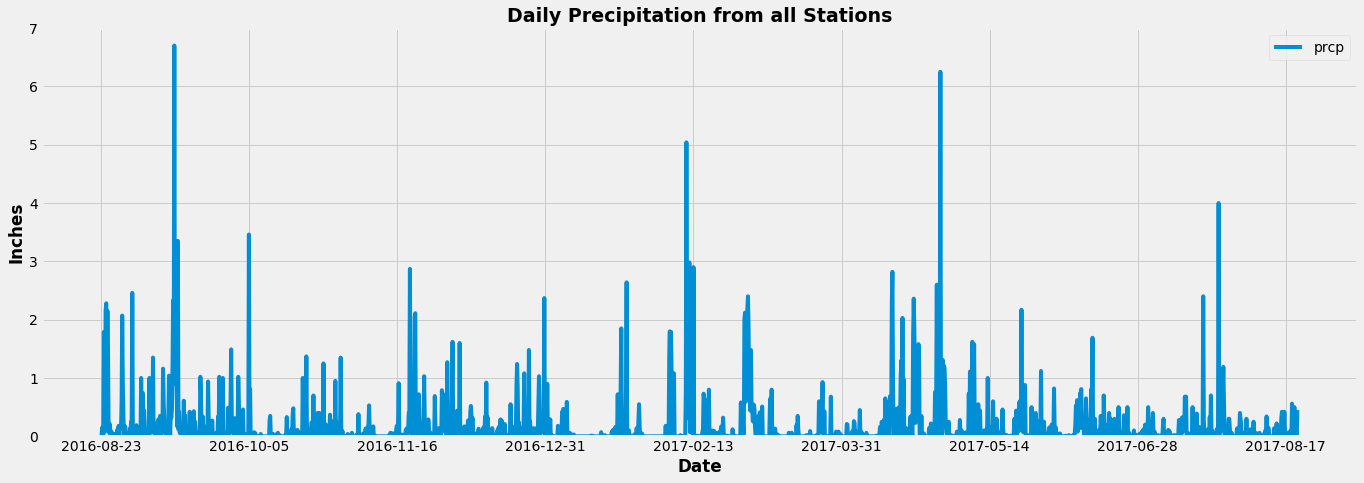

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

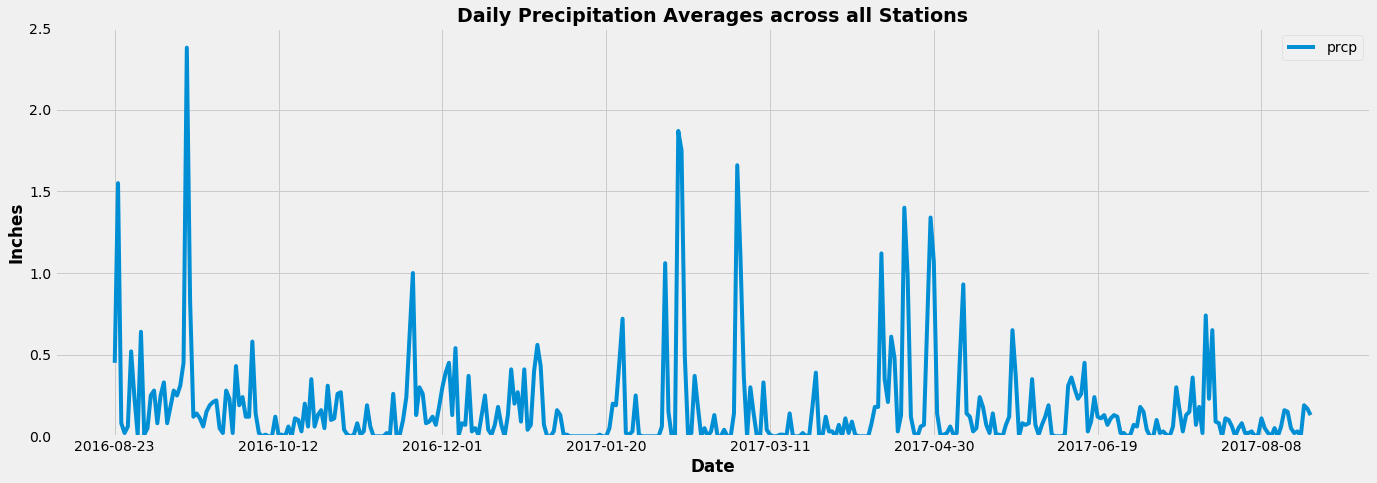

In [5]:
########################################################################
#03    Plot Rainfall                                                   #
#   a- plot precipitation from all stations reporting for past year.   #
#   b- plot precipitation averages from all stations reporting.        #
#      (save image file for both graphs)                               #
########################################################################
                
plt.figure()
rain_df.plot(figsize = (21, 7))
plt.xlabel("Date", fontweight='bold')
plt.ylabel("Inches", fontweight='bold')
plt.ylim(0, 7)
plt.title("Daily Precipitation from all Stations", fontsize = 19, fontweight='bold')
plt.savefig("Images/precipitation_allstations.png")
plt.show()


#b
plt.figure()
rain_grouped.plot(figsize = (21, 7))
plt.xlabel("Date", fontweight='bold')
plt.ylabel("Inches", fontweight='bold')
plt.ylim(0, 2.5)
plt.title("Daily Precipitation Averages across all Stations", fontsize = 19, fontweight='bold')
plt.savefig("Images/precipitation_station_averages.png")
plt.show


In [6]:
###########################################################
#04       Requested Data                                  #
#   a- print summary statistics for rainfall.             #
#   b- show total number of stations.                     #
#   c- list stations and their row count, descending.     #
#   d- list most active station temperature statistics.   #
###########################################################

#a
print('\033[31m' + "All Stations Individual Count Statistics" + '\033[0m')
print(rain_df.describe()) 

print('\n\033[31m' + "Grouped Stations Statistics" +  '\033[0m')
print(rain_grouped.describe())

#b
total_stations = session.query(Measurement.station).distinct().count()
print ('\n\33[31m' + "Total Number of Stations : " + '\33[0m' + str(total_stations))

#c
station_activity = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
                                 order_by(func.count(Measurement.station).desc()).all()
print ('\n\33[31m' + "Stations Activity, descending order" + '\33[0m')
print(station_activity)

#d
most_active_info = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),\
                                 func.avg(Measurement.tobs)).\
                                 filter(Measurement.station == station_activity[0][0]).all()
print('\n\33[31m' + "Most Active station temeratures")
print('\33[91m'" Station Id      min.  max.  avg." + '\33[0m')
print(most_active_info[0])

All Stations Individual Count Statistics
              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

Grouped Stations Statistics
             prcp
count  366.000000
mean     0.170874
std      0.295862
min      0.000000
25%      0.010000
50%      0.070000
75%      0.190000
max      2.380000

Total Number of Stations : 9

Stations Activity, descending order
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

Most Active station temeratures
 Station Id      min.  max.  avg.
('USC00519281', 54.0, 85.0, 71.66378066378067)


In [7]:
###################################################################################
#05     Retrieve Station                                                          #        
#   a- get sorted list of stations ordered by number of temperature readings.     #
#   b- get the station with the highest number of temperature readings.           #
#   c- do above but for last years' worth of data.                                #
#   d- get last 12 months of temperature readings for above mentioned stations.   #
###################################################################################

###   the following code produces a list of stations and their number of TOTAL temperature readings
###  technically, this is what the assignment asks for

#a
temp_counts_overall = session.query(Measurement.station, func.count(Measurement.tobs)).\
                       group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
#b
most_temp_counts_overall = temp_counts_overall [0][0]
print(f"station id with most overall readings :{most_temp_counts_overall}")

###    the following produces a list of stations and their number of temperature readings FOR THE PAST YEAR, realistically
###  this seems like what the assignment should be asking for, since it's concerned with the past years worth of temperatures.

#c
temp_counts_past_year = session.query(Measurement.station, func.count(Measurement.tobs)).\
                        group_by(Measurement.station).filter(Measurement.date >= last_year).\
                        order_by(func.count(Measurement.tobs).desc()).all()
 
most_temp_counts_past_year = temp_counts_past_year [0][0]
print(f"station id with most readings in the past year :{most_temp_counts_past_year}")

#d
temp_readings_a = session.query(Measurement.tobs).\
                                filter(Measurement.station == most_temp_counts_overall).\
                                filter(Measurement.date >= last_year).order_by(Measurement.tobs).all()
temp_df_a = pd.DataFrame(temp_readings_a)

temp_readings_b = session.query(Measurement.station, Measurement.tobs).\
                                filter(Measurement.station == most_temp_counts_past_year).\
                                filter(Measurement.date >= last_year).all()
temp_df_b = pd.DataFrame(temp_readings_a)

station id with most overall readings :USC00519281
station id with most readings in the past year :USC00519397


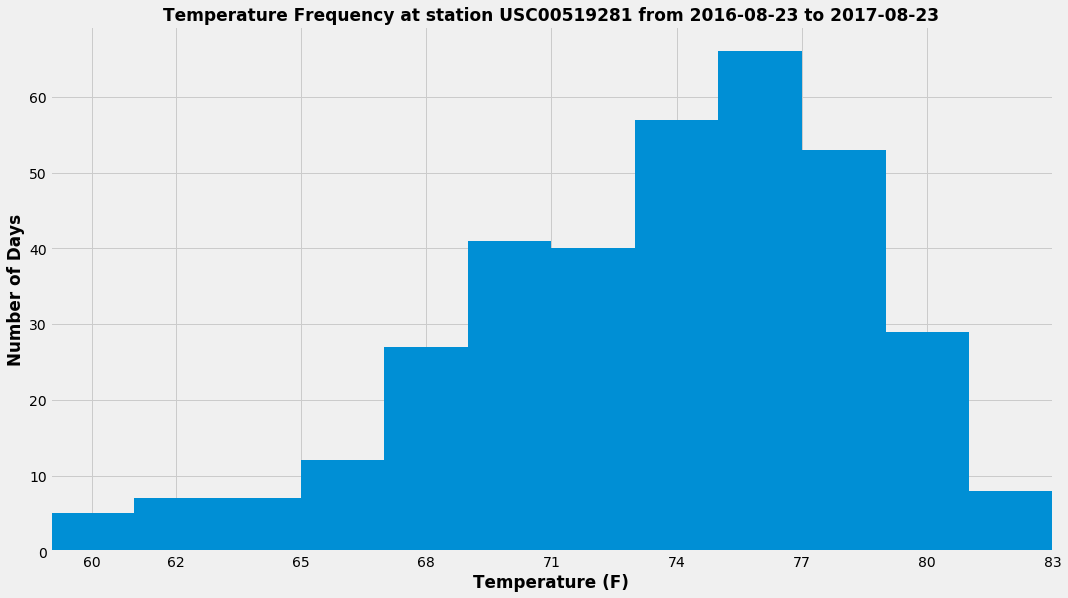

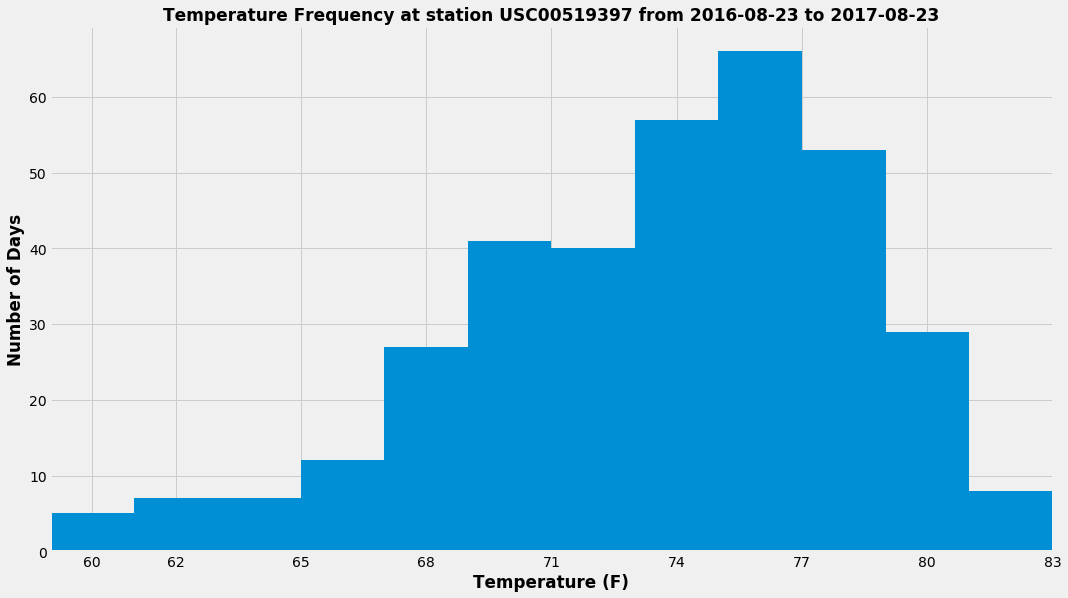

In [8]:
#################################################
#06  histogram                                  #
#   a- histogram temperatures from station_a.   #
#   b- histogram temperatures from station_b.   #
#################################################

#a
plt.figure(figsize=(16,9))
plt.hist(temp_df_a["tobs"], bins=12)
plt.xlabel("Temperature (F)", fontweight='bold')
plt.ylabel("Number of Days", fontweight='bold')
plt.xlim(59,83)
plt.xticks((60,62,65,68,71,74,77,80,83))
plt.title(f"Temperature Frequency at station {most_temp_counts_overall} from {last_year} to {most_recent}", 
          fontsize = 17, fontweight='bold')
plt.savefig("Images/Temperature_freq_histogram1.png")
plt.show()


#b
plt.figure(figsize=(16,9))
plt.hist(temp_df_b["tobs"], bins=12)
plt.xlabel("Temperature (F)", fontweight='bold')
plt.ylabel("Number of Days", fontweight='bold')
plt.xlim(59,83)
plt.xticks((60,62,65,68,71,74,77,80,83))
plt.title(f"Temperature Frequency at station {most_temp_counts_past_year} from {last_year} to {most_recent}", 
          fontsize = 17, fontweight='bold')
plt.savefig("Images/Temperature_freq_histogram2.png")
plt.show()


## Bonus Challenge Assignment

In [9]:
########################################################################################################
#07     Pre-written by Trilogy                                                                         #
#   - This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'   # 
#     and return the minimum, average, and maximum temperatures for that range of dates.               #
########################################################################################################

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


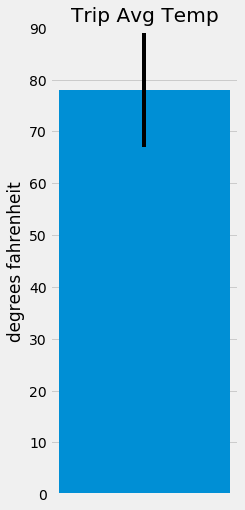

In [10]:
#################################################################
#08    My Vacation (9/1/17 - 9/8/17)                            #
#   a- call calc_temps with my vacation days from a year ago.   #
#   b- extract three values returned, round the average temp.   #
#   c- plot avg temp with min-max as error bar.                 #
#################################################################

#a
cal_temps_array = calc_temps('2016-09-01', '2016-09-08')

#b
tmin, tavg, tmax = cal_temps_array [0]
tavg = round(tavg, 2)

#c
plt.figure(figsize=(3,8))
plt.tight_layout()
plt.bar(0,tavg)
plt.ylim(0, 90)
plt.title("Trip Avg Temp")
plt.ylabel("degrees fahrenheit")
plt.xticks([])
plt.errorbar(0,tavg, yerr=(tmax - tmin), color = 'black')
plt.savefig("Images/Vacationtime_avgtemp_lastyear.png")
plt.show()

In [11]:
##################################################################################################################
#09     Last Years Rain                                                                                          #
#   a- total amount of rainfall per weather station for trip dates using the previous year's matching dates,     #
#      Sort in descending by precipitation amount, list the station, name, latitude, longitude, and elevation.   #
##################################################################################################################

#a
rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,\
                     Station.elevation, func.sum(Measurement.prcp)).\
                     filter(Measurement.station == Station.station).filter(Measurement.prcp != "None").\
                     filter(Measurement.date >= "2016-09-01").filter(Measurement.date <= "2016-09-08").\
                     group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.16),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.99),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.6600000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.47000000000000003),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08)]

In [12]:
########################################################################################
#10       Pre-written by Trilogy                                                       #
#   - Create a query that will calculate the daily normals (i.e. the averages for      #
#     tmin, tmax, and tavg for all historic data matching a specific month and day).   #
########################################################################################

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

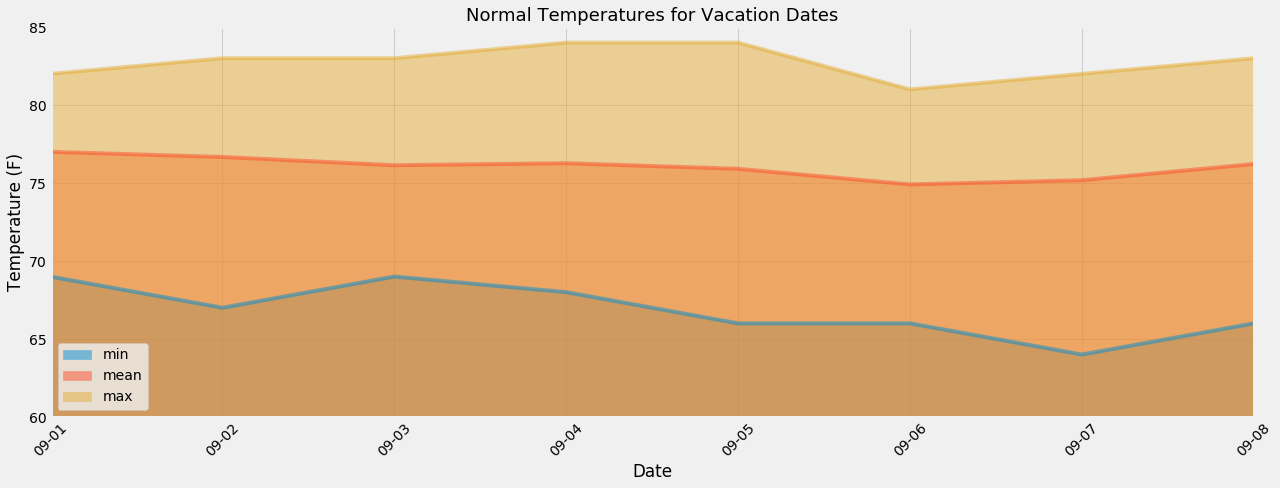

In [13]:
#################################################################################
#11      Daily Averages                                                         #
#   a- define normals list, create xtick locations and vacation dates tuples.   #
#   b- loop thru dates and call daily_normals, fill normals list.               #
#   c- create pd df with dates and normals, index by date.                      #
#   d- area plot results from daily_normals function.                           #
#################################################################################

#a
normals = []
locs = (0,1,2,3,4,5,6,7)
dates = ("09-01","09-02","09-03","09-04","09-05","09-06","09-07","09-08")

#b
for x in range(len(dates)):
    tempval = daily_normals(dates[x])
    normals.append(tempval[0])
    
#c
normals_df = pd.DataFrame(normals, columns=["min","mean","max"])
normals_df["date"] = dates
normals_df["mean"] = round(normals_df["mean"], 2)
normals_df.set_index("date")

#d
normals_df.plot.area(stacked = False, figsize=(18,7))
plt.title("Normal Temperatures for Vacation Dates", fontsize=18)
plt.ylabel("Temperature (F)")
plt.xlabel("Date")
plt.xticks(locs, dates, rotation=45)
plt.xlim(0,7)
plt.ylim(60,85)
plt.tight_layout()
plt.savefig("Images/Vacationtime_normal_temps.png")
plt.show()